In [1]:
# LSTM Time series prediciton

# Importing the libraries
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error


In [2]:
# Some functions to help out with

def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Latency', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

def line_plot_alone(line1, label1=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(20, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.set_ylabel('Latency', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

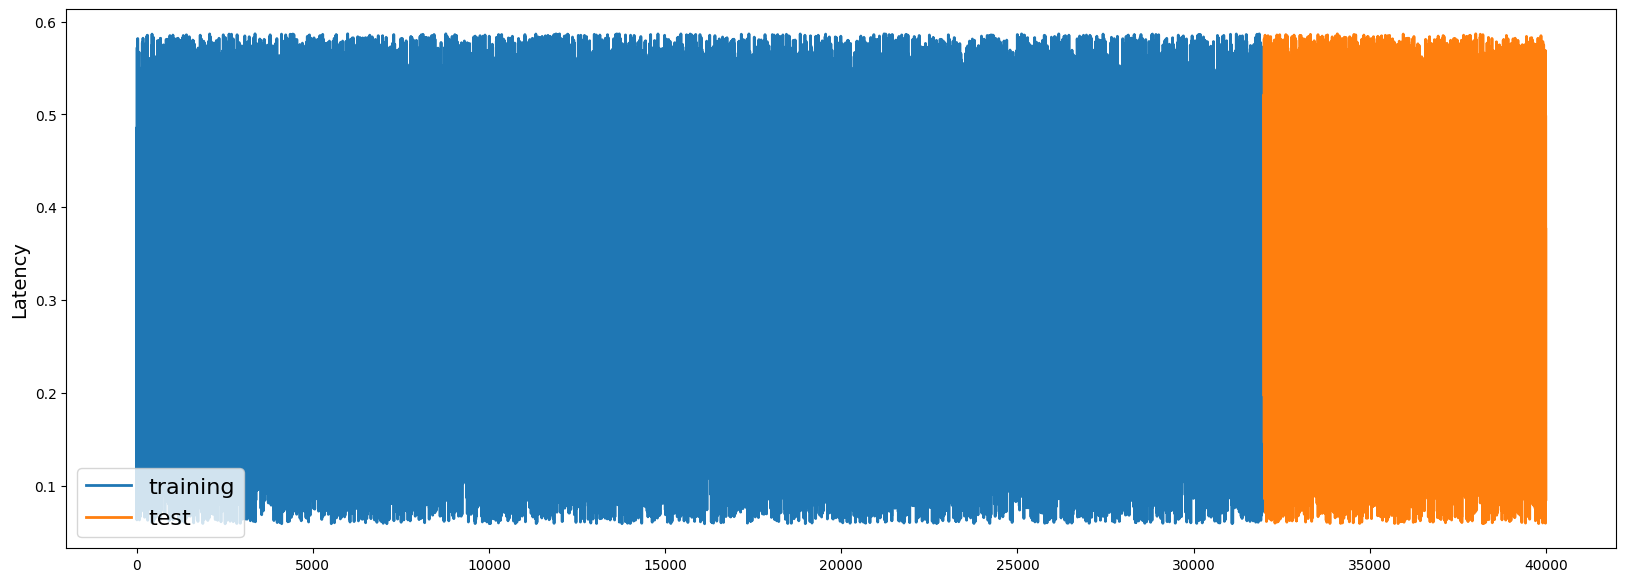

In [12]:
# On récupère le dataFrame
df = pd.read_csv("./data/revised_dataset.csv", sep=';')

# On prend les colonnes qui nous interesse
df = df[["Latence1", "Coord1", "Coord2"]]
df = df.astype(float)

# colonne cible
target_col = 'Latence1'

train, test = train_test_split(df, test_size=0.2) 
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [13]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [14]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [15]:
def prepare_data(df, target_col, window_len=10, zero_base=False, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [16]:
def build_lstm_model(input_data, neurons1, neurons2, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons1, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))

    model.add(Dense(1))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [17]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = False
lstm_neurons = 200
epochs = 20
batch_size = 64
loss = 'mse'
dropout = 0.2
optimizer = keras.optimizers.Adam()

In [18]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


C:\Users\probook\AppData\Local\Temp\ipykernel_19420\57073689.py:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test = test_data[target_col][window_len:].values


In [19]:
bestModel = None
bestScore = 20000

'''
for i in [16, 32, 64, 128, 256]:
  for j in [16, 32, 64, 128, 256]:
      model = build_lstm_model(
          X_train, output_size=1, neurons1=i, neurons2=j, dropout=dropout, loss=loss,
          optimizer=optimizer)
      history = model.fit(
          X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
      preds = model.predict(X_test).squeeze()
      score = mean_squared_error(preds, y_test, squared=False)
      print("score pour i=", i, " et j=", j, " --> ", score)
      if score < bestScore:
        bestScore = score
        bestModel = model
  
print("best model : ", bestModel)
print("best score : ", bestScore)


'''
model = build_lstm_model(
      X_train, neurons1=70, neurons2=32, dropout=dropout, loss=loss,
      optimizer=optimizer)
history = model.fit(
      X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
500/500 [==============================] - 7s 8ms/step - loss: 0.0313
Epoch 2/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0241
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0237
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0236
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0235
Epoch 6/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0235
Epoch 7/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0234
Epoch 8/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0234
Epoch 9/20
500/500 [==============================] - 4s 9ms/step - loss: 0.0234
Epoch 10/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0233
Epoch 11/20
500/500 [==============================] - 4s 7ms/step - loss: 0.0233
Epoch 12/20
500/500 [==============================] - 4s 8ms/step - loss: 0.0233
Epoch 13/20
500/500 [====

  1/250 [..............................] - ETA: 11s

C:\Users\probook\AppData\Local\Temp\ipykernel_19420\365669861.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  targets = test[target_col][window_len:]


250/250 [==============================] - 1s 3ms/step


C:\Users\probook\AppData\Local\Temp\ipykernel_19420\365669861.py:21: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  line_plot(targets[7950:8000], preds[7945:7995], 'actual', 'prediction', lw=3)


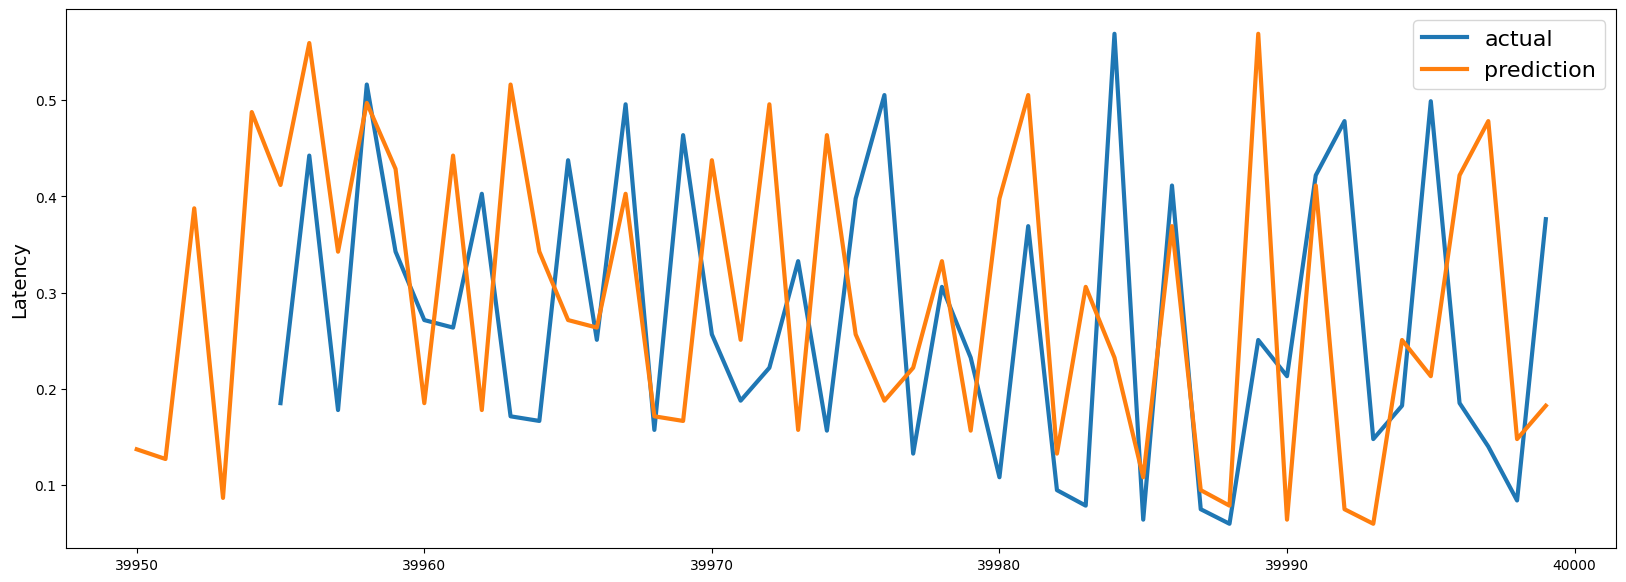

In [27]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

# print(preds)
# print(y_test.shape)

predL0 = []
for i in preds:
    m = 0
    for j in i:
        m+=j
    predL0.append(m/5)

# print(len(predL0), predL0)
predL0 = np.array(predL0)

mean_squared_error(predL0, y_test, squared=False)

preds = test[target_col].values[:-window_len]
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets[7950:8000], preds[7945:7995], 'actual', 'prediction', lw=3)
